In [2]:
import polars as pl
from pathlib import Path

# ---------------------------------------------------
# 1. Paths for Kaggle environment
# ---------------------------------------------------
data_path = Path("/kaggle/input/data-loc")
labels_path = Path("/kaggle/input/labels/labels.csv")

print("📂 Sensor data directory:", data_path)
print("📂 Labels file:", labels_path)

# ---------------------------------------------------
# 2. Load labels (small → eager)
# ---------------------------------------------------
labels_df = pl.read_csv(labels_path)

print(f"📥 Loaded labels: {labels_df.shape[0]} rows, {labels_df.shape[1]} columns")

# Ensure join keys exist
if not {"script_id", "sequence_id"}.issubset(labels_df.columns):
    raise ValueError("❌ labels.csv missing script_id or sequence_id columns!")

# ---------------------------------------------------
# 3. Scan all parquet files lazily
# ---------------------------------------------------
parquet_files = sorted(data_path.glob("data_loc*.parquet"))

if not parquet_files:
    raise RuntimeError("❌ No parquet files found under /kaggle/input/data-loc/")

print(f"📦 Found {len(parquet_files)} parquet files.")

lazy_frames = []
for f in parquet_files:
    print(f"   ➤ Scanning: {f.name}")
    lazy_frames.append(pl.scan_parquet(f))

# ---------------------------------------------------
# 4. Combine all sensor files lazily
# ---------------------------------------------------
combined_lazy = pl.concat(lazy_frames)

# ---------------------------------------------------
# 5. Merge with labels (lazy)
# ---------------------------------------------------
labeled_lazy = combined_lazy.join(
    labels_df.lazy(),
    on=["script_id", "sequence_id"],
    how="left"
)

# ---------------------------------------------------
# 6. Materialize into memory
# ---------------------------------------------------
labeled_df = labeled_lazy.collect()

# ---------------------------------------------------
# 7. Summary
# ---------------------------------------------------
print("\n========================")
print("✅ FINAL DATASET SUMMARY")
print("========================")
print(f"📊 Rows: {labeled_df.shape[0]:,}")
print(f"📐 Columns: {labeled_df.shape[1]}")
print(f"📍 Unique locations: {labeled_df['location'].n_unique()}")
print(f"🏷️ Unique activities: {labeled_df['activity'].n_unique()}")
print("🔬 Sensor channels: acc_x/y/z, gyro_x/y/z, mag_x/y/z")
print("========================\n")

labeled_df.head(10)


📂 Sensor data directory: /kaggle/input/data-loc
📂 Labels file: /kaggle/input/labels/labels.csv
📥 Loaded labels: 34 rows, 3 columns
📦 Found 5 parquet files.
   ➤ Scanning: data_loc1.parquet
   ➤ Scanning: data_loc2.parquet
   ➤ Scanning: data_loc3.parquet
   ➤ Scanning: data_loc4.parquet
   ➤ Scanning: data_loc5.parquet

✅ FINAL DATASET SUMMARY
📊 Rows: 49,259,469
📐 Columns: 16
📍 Unique locations: 5
🏷️ Unique activities: 33
🔬 Sensor channels: acc_x/y/z, gyro_x/y/z, mag_x/y/z



location,script_id,sequence_id,recording_id,inner_filename,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,activity
str,i32,i32,i32,str,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6352e10,0.09098,-9.238028,0.592565,0.447184,0.013043,-0.326072,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6352e10,-8.791509,-0.648829,1.58975,0.12404,-0.406725,0.336453,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6353e10,0.069432,-9.234436,0.593762,0.455436,0.017302,-0.33805,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6353e10,-8.777143,-0.629675,1.587356,0.129364,-0.41684,0.334856,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6354e10,-8.769961,-0.600945,1.606509,0.136817,-0.42589,0.336453,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6354e10,0.098162,-9.224859,0.591368,0.46209,0.02023,-0.349496,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6355e10,-8.769961,-0.56982,1.623269,0.141076,-0.430681,0.341244,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6355e10,0.02873,-9.194932,0.592565,0.470874,0.028481,-0.359611,0.0,0.0,0.0,"""Health activity"""
"""loc1""",1,1,1,"""loc1_script1_seq1_rec1-metadat…",5.6356e10,-8.746018,-0.574608,1.596933,0.141076,-0.435472,0.345503,0.0,0.0,0.0,"""Health activity"""


In [5]:
import polars as pl

sensor_cols = [
    "acc_x", "acc_y", "acc_z",
    "gyro_x", "gyro_y", "gyro_z",
    "mag_x", "mag_y", "mag_z"
]

# Create aggregation expressions for each stat
agg_exprs = []

for col in sensor_cols:
    agg_exprs.append(pl.col(col).mean().alias(f"{col}_mean"))
    agg_exprs.append(pl.col(col).std().alias(f"{col}_std"))
    agg_exprs.append(pl.col(col).min().alias(f"{col}_min"))
    agg_exprs.append(pl.col(col).max().alias(f"{col}_max"))

# Group by activity and aggregate
features = labeled_df.group_by("activity").agg(agg_exprs)

print(features.shape)
features.head()


(33, 37)


activity,acc_x_mean,acc_x_std,acc_x_min,acc_x_max,acc_y_mean,acc_y_std,acc_y_min,acc_y_max,acc_z_mean,acc_z_std,acc_z_min,acc_z_max,gyro_x_mean,gyro_x_std,gyro_x_min,gyro_x_max,gyro_y_mean,gyro_y_std,gyro_y_min,gyro_y_max,gyro_z_mean,gyro_z_std,gyro_z_min,gyro_z_max,mag_x_mean,mag_x_std,mag_x_min,mag_x_max,mag_y_mean,mag_y_std,mag_y_min,mag_y_max,mag_z_mean,mag_z_std,mag_z_min,mag_z_max
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""Room Decoration""",-3.779721,5.403954,-65.388046,13.563152,-3.200372,4.98258,-29.897594,14.358027,3.326656,2.595637,-10.831368,28.112717,0.005042,0.47351,-7.487142,6.348951,-0.000938,0.446023,-7.917557,6.670498,0.011142,0.291266,-3.033932,2.887532,-0.183932,2.573323,-48.09166,12.871237,-0.064416,1.731162,-43.396839,37.793015,-0.102298,1.90613,-60.094078,18.316507
"""Texting and Reading""",-3.001997,5.641989,-16.859968,10.929531,-2.359252,5.173315,-17.452534,10.637438,4.370353,2.257344,-5.432444,12.595895,0.000182,0.479591,-4.892941,6.263773,-0.003326,0.450967,-5.198783,6.597032,-0.006033,0.304166,-3.146793,3.592912,-0.180726,2.506803,-46.172184,4.42734,-0.099959,1.749782,-45.121975,42.796104,-0.110272,2.126545,-74.328888,22.519047
"""Clean the place""",-1.778087,5.571637,-21.727381,15.103822,-1.294242,5.225159,-22.990322,13.524845,5.330458,2.526061,-8.204929,18.205509,0.015056,0.525463,-6.570947,8.621606,-0.005227,0.499783,-6.558969,8.690547,0.001476,0.402605,-3.072262,2.988681,-0.136911,2.142014,-53.727036,31.319729,-0.10551,1.945754,-50.075089,35.681732,-0.119785,2.088268,-59.558025,19.340748
"""Catch up on what happened""",-3.453038,5.44003,-16.46253,8.962694,-2.715464,5.106267,-22.600067,10.251972,3.820297,2.432078,-9.045294,12.348095,0.005217,0.198681,-5.892185,5.632392,0.002182,0.185573,-6.064936,5.703729,-0.002244,0.10893,-1.910648,2.140096,-0.183241,2.508106,-52.640278,0.0,-0.040162,1.952431,-45.839252,43.351131,-0.07999,1.345088,-43.896313,12.192845
"""Caffeination""",-4.190034,5.282359,-25.172636,9.414001,-3.125242,5.291024,-26.375723,10.527305,3.070554,2.106621,-5.291186,10.681731,0.00721,0.468189,-6.832869,5.520596,0.00487,0.444062,-6.982728,5.768677,-0.001845,0.276642,-2.657552,2.978833,-0.199576,2.780772,-53.557827,2.945405,-0.014991,1.265837,-51.178181,45.216984,-0.124023,2.603633,-84.135399,34.126743


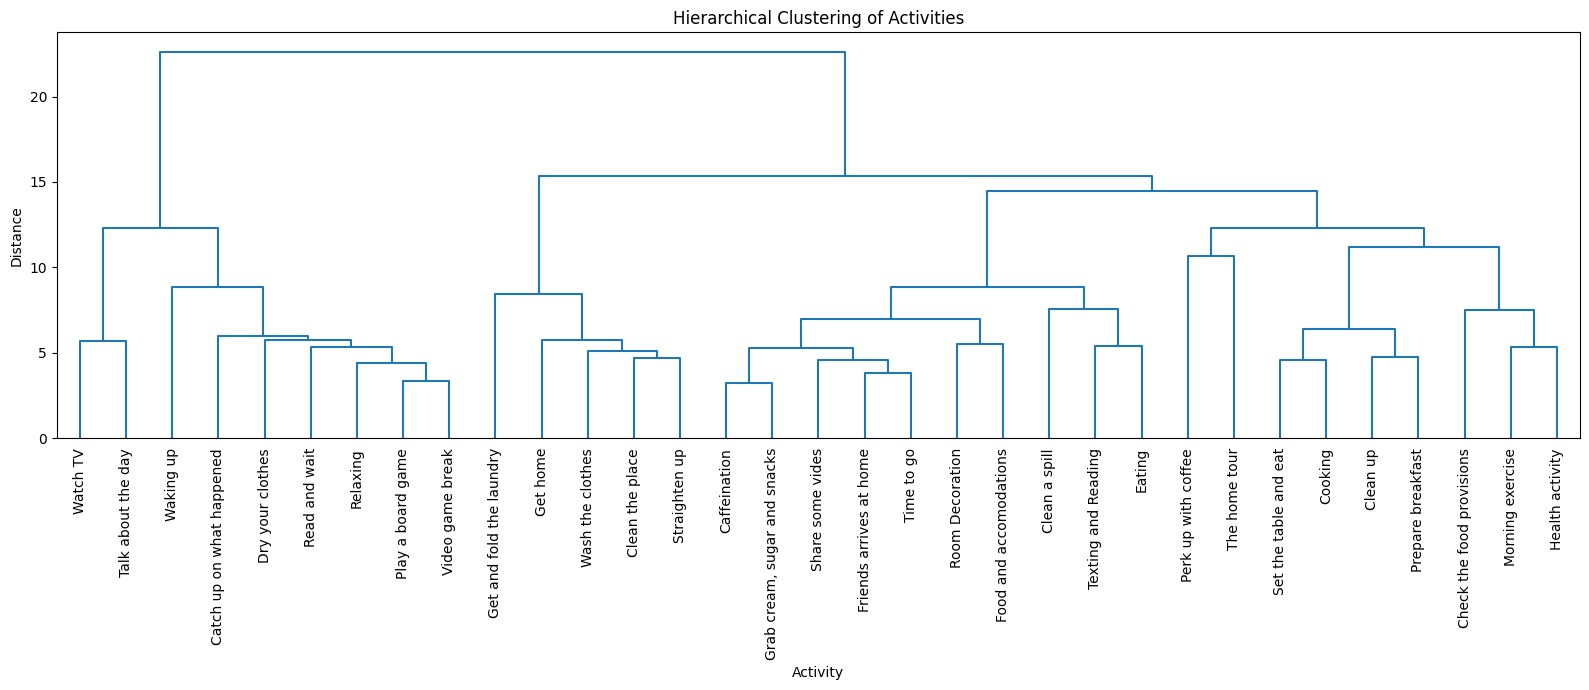

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# -----------------------------
# 3. Convert to NumPy
# -----------------------------
X = features.drop("activity").to_numpy()
activity_names = features["activity"].to_list()

# -----------------------------
# 4. Scale features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 5. Compute hierarchical clustering
# -----------------------------
Z = linkage(X_scaled, method="ward")

# -----------------------------
# 6. Plot dendrogram
# -----------------------------
plt.figure(figsize=(16, 7))
dendrogram(
    Z,
    labels=activity_names,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0  # all colors distinct
)
plt.title("Hierarchical Clustering of Activities")
plt.xlabel("Activity")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [26]:
from scipy.cluster.hierarchy import fcluster
import pandas as pd

# 1. Generate 4 clusters from your linkage matrix
clusters = fcluster(Z, t=4, criterion='maxclust')

# 2. Create activity-to-cluster mapping
activity_to_cluster_df = pd.DataFrame({
    "activity": activity_names,
    "cluster": clusters
})

# 3. Sort for readability
activity_to_cluster_df = activity_to_cluster_df.sort_values("cluster").reset_index(drop=True)

print(activity_to_cluster_df)


                        activity  cluster
0               Dry your clothes        1
1                  Read and wait        1
2      Catch up on what happened        1
3              Play a board game        1
4                       Watch TV        1
5                       Relaxing        1
6             Talk about the day        1
7                      Waking up        1
8               Video game break        1
9       Get and fold the laundry        2
10                      Get home        2
11              Wash the clothes        2
12               Clean the place        2
13                 Straighten up        2
14  Grab cream, sugar and snacks        3
15           Texting and Reading        3
16                  Caffeination        3
17                        Eating        3
18                 Clean a spill        3
19                    Time to go        3
20               Room Decoration        3
21              Share some vides        3
22       Friends arrives at home  

In [23]:
print(activity_to_cluster.to_pandas())


                        activity  cluster
0                Room Decoration        2
1            Texting and Reading        0
2                Clean the place        0
3      Catch up on what happened        1
4                   Caffeination        2
5                       Watch TV        1
6                  Clean a spill        2
7             Talk about the day        2
8               Share some vides        2
9                  Straighten up        0
10       Friends arrives at home        2
11                      Clean up        0
12              Morning exercise        0
13        Food and accomodations        0
14               Health activity        0
15                      Get home        0
16              Dry your clothes        1
17         Set the table and eat        3
18                     Waking up        1
19           Perk up with coffee        3
20                    Time to go        2
21                 The home tour        3
22  Grab cream, sugar and snacks  

In [27]:
import polars as pl

# Convert activity→cluster table to Polars
cluster_map = pl.DataFrame(activity_to_cluster_df)

# Merge cluster label into full dataset
labeled_df = labeled_df.join(
    cluster_map,
    on="activity",
    how="left"
)

print(labeled_df.head())
print(labeled_df["cluster"].unique())


shape: (5, 17)
┌──────────┬───────────┬─────────────┬──────────────┬───┬───────┬───────┬──────────┬─────────┐
│ location ┆ script_id ┆ sequence_id ┆ recording_id ┆ … ┆ mag_y ┆ mag_z ┆ activity ┆ cluster │
│ ---      ┆ ---       ┆ ---         ┆ ---          ┆   ┆ ---   ┆ ---   ┆ ---      ┆ ---     │
│ str      ┆ i32       ┆ i32         ┆ i32          ┆   ┆ f32   ┆ f32   ┆ str      ┆ i32     │
╞══════════╪═══════════╪═════════════╪══════════════╪═══╪═══════╪═══════╪══════════╪═════════╡
│ loc1     ┆ 1         ┆ 1           ┆ 1            ┆ … ┆ 0.0   ┆ 0.0   ┆ Health   ┆ 4       │
│          ┆           ┆             ┆              ┆   ┆       ┆       ┆ activity ┆         │
│ loc1     ┆ 1         ┆ 1           ┆ 1            ┆ … ┆ 0.0   ┆ 0.0   ┆ Health   ┆ 4       │
│          ┆           ┆             ┆              ┆   ┆       ┆       ┆ activity ┆         │
│ loc1     ┆ 1         ┆ 1           ┆ 1            ┆ … ┆ 0.0   ┆ 0.0   ┆ Health   ┆ 4       │
│          ┆           ┆           

In [30]:
# Count unique videos per cluster
video_counts = (
    labeled_df
    .select([
        "script_id",
        "sequence_id",
        "recording_id",
        "cluster"
    ])
    .unique()      # keep only unique videos
    .group_by("cluster")
    .count()
    .sort("cluster")
)

print(video_counts)


shape: (4, 2)
┌─────────┬───────┐
│ cluster ┆ count │
│ ---     ┆ ---   │
│ i32     ┆ u32   │
╞═════════╪═══════╡
│ 1       ┆ 11    │
│ 2       ┆ 5     │
│ 3       ┆ 17    │
│ 4       ┆ 14    │
└─────────┴───────┘


/tmp/ipykernel_47/3602501598.py:12: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


In [31]:
row_counts = (
    labeled_df
    .group_by("cluster")
    .count()
    .sort("cluster")
)

print(row_counts)


shape: (4, 2)
┌─────────┬──────────┐
│ cluster ┆ count    │
│ ---     ┆ ---      │
│ i32     ┆ u32      │
╞═════════╪══════════╡
│ 1       ┆ 9643385  │
│ 2       ┆ 5881007  │
│ 3       ┆ 13558694 │
│ 4       ┆ 20176383 │
└─────────┴──────────┘


/tmp/ipykernel_47/110994007.py:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


In [33]:
import polars as pl

# -------------------------------------------
# 1. Get unique videos with cluster label
# -------------------------------------------
videos = (
    labeled_df
    .select(["script_id", "sequence_id", "recording_id", "cluster"])
    .unique()
)

# -------------------------------------------
# 2. Balance the videos
# -------------------------------------------
VIDEOS_PER_CLUSTER = 5

balanced = (
    videos
    .group_by("cluster")
    .map_groups(lambda df: df.sample(n=min(VIDEOS_PER_CLUSTER, df.height), shuffle=True))
)

print(balanced)

# -------------------------------------------
# 3. Train/test split (4 train, 1 test)
# -------------------------------------------
train_vids = []
test_vids = []

for cl in balanced["cluster"].unique():
    df_cl = balanced.filter(pl.col("cluster") == cl)

    # Shuffle correctly in Polars
    df_cl = df_cl.sample(n=df_cl.height, shuffle=True)

    # 1 test video, rest train
    test_vids.append(df_cl.head(1))
    train_vids.append(df_cl.tail(df_cl.height - 1))

train_vids = pl.concat(train_vids)
test_vids  = pl.concat(test_vids)


# -------------------------------------------
# 4. Retrieve full sensor rows for train/test
# -------------------------------------------
train_df = labeled_df.join(
    train_vids,
    on=["script_id", "sequence_id", "recording_id"],
    how="inner"
)

test_df = labeled_df.join(
    test_vids,
    on=["script_id", "sequence_id", "recording_id"],
    how="inner"
)

print(train_df.shape)
print(test_df.shape)


shape: (20, 4)
┌───────────┬─────────────┬──────────────┬─────────┐
│ script_id ┆ sequence_id ┆ recording_id ┆ cluster │
│ ---       ┆ ---         ┆ ---          ┆ ---     │
│ i32       ┆ i32         ┆ i32          ┆ i32     │
╞═══════════╪═════════════╪══════════════╪═════════╡
│ 4         ┆ 5           ┆ 1            ┆ 3       │
│ 3         ┆ 1           ┆ 2            ┆ 3       │
│ 1         ┆ 4           ┆ 1            ┆ 3       │
│ 2         ┆ 4           ┆ 1            ┆ 3       │
│ 3         ┆ 1           ┆ 1            ┆ 3       │
│ …         ┆ …           ┆ …            ┆ …       │
│ 2         ┆ 5           ┆ 2            ┆ 1       │
│ 5         ┆ 4           ┆ 1            ┆ 1       │
│ 3         ┆ 2           ┆ 1            ┆ 1       │
│ 5         ┆ 5           ┆ 1            ┆ 1       │
│ 1         ┆ 5           ┆ 1            ┆ 1       │
└───────────┴─────────────┴──────────────┴─────────┘
(17323573, 18)
(4350851, 18)


In [44]:
train_pd = train_df.to_pandas()
test_pd = test_df.to_pandas()


In [45]:
DOWNSAMPLE_FACTOR = 5


In [46]:
train_down = (
    train_pd
    .sort_values(["script_id", "sequence_id", "recording_id", "timestamp"])
    .groupby(["script_id", "sequence_id", "recording_id"])
    .nth[::DOWNSAMPLE_FACTOR]
)


In [47]:
test_down = (
    test_pd
    .sort_values(["script_id", "sequence_id", "recording_id", "timestamp"])
    .groupby(["script_id", "sequence_id", "recording_id"])
    .nth[::DOWNSAMPLE_FACTOR]
)


In [48]:
print("Train before:", train_pd.shape)
print("Train after:", train_down.shape)

print("Test before:", test_pd.shape)
print("Test after:", test_down.shape)


Train before: (17323573, 18)
Train after: (3464722, 18)
Test before: (4350851, 18)
Test after: (870172, 18)


In [50]:
train_down.to_parquet("train_down.parquet", index=False)
test_down.to_parquet("test_down.parquet", index=False)